In [1]:
import math
import numpy as np
import scipy.sparse as sp
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from box import Box

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

In [2]:
class GMF(nn.Module):
    def __init__(self, num_user, num_item, num_factor):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)
        
        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor, 1, bias = False)
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1)
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)

        output = self.predict_layer(user_emb * item_emb)

        return output.view(-1)

In [3]:
def swish(x):
    return x.mul(torch.sigmoid(x))

def log_norm_pdf(x, mu, logvar):
    return -0.5*(logvar + np.log(2 * np.pi) + (x - mu).pow(2) / logvar.exp())

class CompositePrior(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, mixture_weights=[3/20, 3/4, 1/10]):
        super(CompositePrior, self).__init__()
        
        self.mixture_weights = mixture_weights
        
        self.mu_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.mu_prior.data.fill_(0)
        
        self.logvar_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_prior.data.fill_(0)
        
        self.logvar_uniform_prior = nn.Parameter(torch.Tensor(1, latent_dim), requires_grad=False)
        self.logvar_uniform_prior.data.fill_(10)
        
        self.encoder_old = Encoder(hidden_dim, latent_dim, input_dim)
        self.encoder_old.requires_grad_(False)
        
    def forward(self, x, z):

        post_mu, post_logvar = self.encoder_old(x, dropout_rate = 0)

        stnd_prior = log_norm_pdf(z, self.mu_prior, self.logvar_prior)
        post_prior = log_norm_pdf(z, post_mu, post_logvar)
        unif_prior = log_norm_pdf(z, self.mu_prior, self.logvar_uniform_prior)
        
        gaussians = [stnd_prior, post_prior, unif_prior]
        gaussians = [g.add(np.log(w)) for g, w in zip(gaussians, self.mixture_weights)]

        density_per_gaussian = torch.stack(gaussians, dim=-1)

        return torch.logsumexp(density_per_gaussian, dim=-1)

    
class Encoder(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, eps=1e-1):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.ln4 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.ln5 = nn.LayerNorm(hidden_dim, eps=eps)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x, dropout_rate):
        norm = x.pow(2).sum(dim=-1).sqrt()
        x = x / norm[:, None]
    
        x = F.dropout(x, p=dropout_rate, training=self.training)
        
        h1 = self.ln1(swish(self.fc1(x)))
        h2 = self.ln2(swish(self.fc2(h1) + h1))
        h3 = self.ln3(swish(self.fc3(h2) + h1 + h2))
        h4 = self.ln4(swish(self.fc4(h3) + h1 + h2 + h3))
        h5 = self.ln5(swish(self.fc5(h4) + h1 + h2 + h3 + h4))
        return self.fc_mu(h5), self.fc_logvar(h5)


class RecVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim = 600, latent_dim = 200):
        super(RecVAE, self).__init__()

        self.encoder = Encoder(hidden_dim, latent_dim, input_dim)
        self.prior = CompositePrior(hidden_dim, latent_dim, input_dim)
        self.decoder = nn.Linear(latent_dim, input_dim)
        
    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, user_ratings, beta=None, gamma=0.005, dropout_rate=0.5, calculate_loss=True):
        mu, logvar = self.encoder(user_ratings, dropout_rate=dropout_rate)    
        z = self.reparameterize(mu, logvar)
        x_pred = self.decoder(z)

        if calculate_loss:
            if gamma:
                norm = user_ratings.sum(dim=-1)
                kl_weight = gamma * norm
            elif beta:
                kl_weight = beta

            mll = (F.log_softmax(x_pred, dim=-1) * user_ratings).sum(dim=-1).mean()
            kld = (log_norm_pdf(z, mu, logvar) - self.prior(user_ratings, z)).sum(dim=-1).mul(kl_weight).mean()
            negative_elbo = -(mll - kld)
            
            return (mll, kld), negative_elbo
            
        else:
            return x_pred

    def update_prior(self):
        self.prior.encoder_old.load_state_dict(deepcopy(self.encoder.state_dict()))

# 1. 학습 설정

In [4]:
config = {
    'data_path' : "/opt/ml/input/data/train" , # 데이터 경로
    'model_path' : "../model",
    
    'submission_path' : "../submission",
    'submission_name' : 'EASE_v8_submission.csv',

    'candidate_item_num' : 5,
    'valid_samples' : 10, # 검증에 사용할 sample 수
    'seed' : 22,
    'reg' : 750,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

# 2. 데이터 전처리

In [5]:
class MakeMatrixDataSet():
    """
    MatrixDataSet 생성
    """
    def __init__(self, config):
        self.config = config
        self.df = pd.read_csv(os.path.join(self.config.data_path, 'train_ratings.csv'))
        
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('item')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user')
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['item'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user'].apply(lambda x : self.user_encoder[x])

        self.user_train, self.user_valid = self.generate_sequence_data()

    def generate_encoder_decoder(self, col : str) -> dict:
        """
        encoder, decoder 생성

        Args:
            col (str): 생성할 columns 명
        Returns:
            dict: 생성된 user encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data 생성

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['item_idx'], self.df['time']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid

    def make_matrix(self, user_list, train = True):
        """
        user_item_dict를 바탕으로 행렬 생성
        """
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
        return mat

    def make_sparse_matrix(self, test = False):
        X = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        
        for user in self.user_train.keys():
            item_list = self.user_train[user]
            X[user, item_list] = 1.0
        
        if test:
            for user in self.user_valid.keys():
                item_list = self.user_valid[user]
                X[user, item_list] = 1.0

        return X.tocsr()
    
    def pseudo_make_sparse_matrix(self, user2rec):
        X = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        
        for user in self.user_train.keys():
            item_list = self.user_train[user] + user2rec[user]
            X[user, item_list] = 1.0

        return X.tocsr()


    def make_year_candidate_item(self, train = True):
        user_pro_df = pd.read_csv(os.path.join(self.config.data_path, 'user_pro.csv'))
        item_pro_df = pd.read_csv(os.path.join(self.config.data_path, 'item_pro.csv'))

        item_pro_df['item'] = item_pro_df['item'].apply(lambda x : self.item_encoder[x])
        item_pro_df['year'] = item_pro_df['year'].astype(int)

        user_pro_df['user'] = user_pro_df['user'].apply(lambda x : self.user_encoder[x])
        user_pro_df['max_year'] = user_pro_df['max_year'].astype(int)
        
        year2item_list = {}
        year_list = user_pro_df['max_year'].unique().tolist()
        for year in year_list:
            item_list = item_pro_df[item_pro_df['year'] <= year + 1]['item'].tolist()
            year2item_list[year + 1] = item_list

        all_item_list = [i for i in range(self.num_item)]
        group_df = user_pro_df.groupby('user')
        candidate = {}
        if train:
            for user, df in group_df:
                max_year = df['max_year'].values[0]
                candidate_item_list = year2item_list[max_year + 1]
                candidate_item_list = set(all_item_list) - set(candidate_item_list)
                candidate_item_list = list(candidate_item_list | set(self.user_train[user]))
                candidate[user] = candidate_item_list
        else:
            for user, df in group_df:
                max_year = df['max_year'].values[0]
                candidate_item_list = year2item_list[max_year + 1]
                candidate_item_list = set(all_item_list) - set(candidate_item_list)
                candidate_item_list = candidate_item_list | set(self.user_train[user])
                candidate_item_list = list(candidate_item_list | set(self.user_valid[user]))
                candidate[user] = candidate_item_list

        return candidate

    def make_cos_candidate_item(self, candidate_item_num, train = True):
        gmf = GMF(
            num_user = self.num_user, 
            num_item = self.num_item, 
            num_factor = 512).to(device)

        gmf.load_state_dict(torch.load(os.path.join(self.config.model_path, 'GMF_v1.pt')))
        movie_emb = gmf.item_emb.weight.data.cpu()
        
        cos_mm = torch.nn.CosineSimilarity(dim=1)
        cos_sim_list = []
        for target_item in range(len(movie_emb)):
            cos_sim_score = cos_mm(movie_emb[target_item], movie_emb)
            cos_sim_index = cos_sim_score.argsort()
            cos_sim_list.append(cos_sim_index.numpy()[::-1][:candidate_item_num + 1].tolist())
        
        cos_sim_list = np.array(cos_sim_list)

        candidate = {}
        if train:
            for user in self.user_train.keys():
                candidate_item_list = set(cos_sim_list[self.user_train[user], :].reshape(-1).tolist())
                candidate_item_list = list(candidate_item_list - set(self.user_train[user]))
                candidate[user] = candidate_item_list
        else:
            for user in self.user_train.keys():
                candidate_item_list = set(cos_sim_list[self.user_train[user] + self.user_valid[user], :].reshape(-1).tolist())
                candidate_item_list = candidate_item_list - set(self.user_train[user])
                candidate_item_list = list(candidate_item_list - set(self.user_valid[user]))
                candidate[user] = candidate_item_list
        
        return candidate

    def m_s_m(self, candidate):
        X = sp.dok_matrix((self.num_user, self.num_item), dtype=np.float32)
        for user in candidate.keys():
            item_list = candidate[user]
            X[user, item_list] = 1.0

        return X.tocsr()

In [6]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# 3. 모델

In [7]:
class EASE():
    def __init__(self, X, reg):
        self.X = self._convert_sp_mat_to_sp_tensor(X)
        self.reg = reg
    
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res
    
    def fit(self):
        '''

        진짜 정말 간단한 식으로 모델을 만듬

        '''
        G = self.X.to_dense().t() @ self.X.to_dense()
        diagIndices = torch.eye(G.shape[0]) == 1
        G[diagIndices] += self.reg

        P = G.inverse()
        B = P / (-1 * P.diag())
        B[diagIndices] = 0
        
        self.B = B
        self.pred = self.X.to_dense() @ B

# 4. 학습 함수

In [18]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

# hit == recall == precision
def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def evaluate(model, X, user_train, user_valid, user_list):

    mat = torch.from_numpy(X)

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat = model.pred.cpu()
    recon_mat[mat == 1] = -np.inf
    rec_list = recon_mat.argsort(dim = 1)

    for user, rec in enumerate(rec_list):
        if user in user_list:
            uv = user_valid[user]
            up = rec[-10:].cpu().numpy().tolist()[::-1]
            NDCG += get_ndcg(pred_list = up, true_list = uv)
            HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(user_list)
    HIT /= len(user_list)

    return NDCG, HIT


def predict(model, X):
    user2rec = {}

    recon_mat = model.pred.cpu()
    score = recon_mat * torch.from_numpy(1 - X)
    rec_list = score.argsort(dim = 1)

    for user, rec in enumerate(rec_list):
        up = rec[-10:].cpu().numpy().tolist()
        user2rec[user] = up
    
    return user2rec

# 5. 학습

In [9]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [13]:
zero_df = pd.read_csv('zero_df.csv')
user_list = zero_df['user'].tolist()

In [14]:
new_X = X[user_list, :]

In [19]:
for reg in [680, 700, 650, 600]:
    model = EASE(X = X, reg = reg)
    model.fit()
    ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid, user_list = user_list)
    print(f'reg: {reg}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

reg: 680| NDCG@10: 0.20609| HIT@10: 0.13156
reg: 700| NDCG@10: 0.20616| HIT@10: 0.13152
reg: 650| NDCG@10: 0.20599| HIT@10: 0.13147
reg: 600| NDCG@10: 0.20585| HIT@10: 0.13142


In [24]:
X_test = make_matrix_data_set.make_sparse_matrix(test = True)
model = EASE(X = X_test, reg = 100000000)
model.fit()

In [25]:
def predict(model, X, user_list):
    user2rec = {}

    mat = torch.from_numpy(X)

    recon_mat = model.pred.cpu()
    recon_mat[mat == 1] = -np.inf
    rec_list = recon_mat.argsort(dim = 1)

    for user, rec in enumerate(rec_list):
        if user in user_list:
            up = rec[-10:].cpu().numpy().tolist()[::-1]
            user2rec[user] = up
    
    return user2rec

In [26]:
user2rec = predict(model = model, X = X_test.todense(), user_list = user_list)

In [27]:
submision = []
users = user2rec.keys()
for user in users:
    rec_item_list = user2rec[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

In [29]:
output = pd.read_csv('output.csv')

In [ ]:
submision['user'].unique().tolist()

In [33]:
want_user_list = list(set(output['user'].unique().tolist()) - set(submision['user'].unique().tolist()))

In [40]:
final_df = pd.concat([output.set_index('user').loc[want_user_list, :].reset_index(), submision]).sort_values('user').reset_index(drop = True)

In [42]:
final_df.to_csv('fina.csv', index = False)

In [11]:
candidate = make_matrix_data_set.make_year_candidate_item(train = True)
# candidate = make_matrix_data_set.make_cos_candidate_item(candidate_item_num = config.candidate_item_num, train = True)

In [12]:
new_X = make_matrix_data_set.m_s_m(candidate)
# new_X = 1 - new_X.todense() # make_cos_candidate_item 사용할 때

In [15]:
ndcg, hit = evaluate(model = model, X = new_X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.22955| HIT@10: 0.20386


In [16]:
ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.22952| HIT@10: 0.20384


In [11]:
model = EASE(X = X.T, reg = 4400)
model.fit()
ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.22594| HIT@10: 0.20021


```

연도 필터링 NDCG@10: 0.81342| HIT@10: 0.20386

reg: 750| NDCG@10: 0.81333| HIT@10: 0.20384
```

```
reg: 4400| NDCG@10: 0.80065| HIT@10: 0.20021
```

In [12]:
for reg in [4800, 4700, 4600, 4500, 4400, 4300, 4200, 4100, 4000]:
    model = EASE(X = X.T, reg = reg)
    model.fit()
    ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid)
    print(f'reg: {reg}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

reg: 4800| NDCG@10: 0.79857| HIT@10: 0.20000
reg: 4700| NDCG@10: 0.79786| HIT@10: 0.19994
reg: 4600| NDCG@10: 0.79932| HIT@10: 0.20013
reg: 4500| NDCG@10: 0.80055| HIT@10: 0.20017
reg: 4400| NDCG@10: 0.80065| HIT@10: 0.20021
reg: 4300| NDCG@10: 0.80003| HIT@10: 0.20011
reg: 4200| NDCG@10: 0.79924| HIT@10: 0.19998


In [ ]:
for candidate_item_num in range(1, 20):
    candidate = make_matrix_data_set.make_cos_candidate_item(candidate_item_num = candidate_item_num, train = True)
    new_X = make_matrix_data_set.m_s_m(candidate)
    new_X = 1 - new_X.todense()

    ndcg, hit = evaluate(model = model, X = new_X, user_train = user_train, user_valid = user_valid)
    print(f'candidate_item_num: {candidate_item_num}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

reg = 1000

규제가 높아지면 후보 집단 생성이 더 좋은 성능을 가져다 주지는 않음

이 이유는 현재 후보 집단 임베딩의 낮은 성능 때문인 것으로 생각됨

```
candidate_item_num: 1| NDCG@10: 0.61763| HIT@10: 0.16217
candidate_item_num: 2| NDCG@10: 0.74284| HIT@10: 0.18944
candidate_item_num: 3| NDCG@10: 0.77578| HIT@10: 0.19632
candidate_item_num: 4| NDCG@10: 0.79034| HIT@10: 0.19934
candidate_item_num: 5| NDCG@10: 0.79921| HIT@10: 0.20084
candidate_item_num: 6| NDCG@10: 0.80333| HIT@10: 0.20157
candidate_item_num: 7| NDCG@10: 0.80574| HIT@10: 0.20211
candidate_item_num: 8| NDCG@10: 0.80748| HIT@10: 0.20246
candidate_item_num: 9| NDCG@10: 0.80879| HIT@10: 0.20280

all = NDCG@10: 0.81406| HIT@10: 0.20379

year = NDCG@10: 0.81417| HIT@10: 0.20382

```

reg = 0.001
```
candidate_item_num: 1| NDCG@10: 0.58045| HIT@10: 0.14915
candidate_item_num: 2| NDCG@10: 0.67349| HIT@10: 0.16913
candidate_item_num: 3| NDCG@10: 0.69687| HIT@10: 0.17347
candidate_item_num: 4| NDCG@10: 0.70453| HIT@10: 0.17469
candidate_item_num: 5| NDCG@10: 0.70501| HIT@10: 0.17461
candidate_item_num: 6| NDCG@10: 0.70404| HIT@10: 0.17441
candidate_item_num: 7| NDCG@10: 0.70468| HIT@10: 0.17448
candidate_item_num: 8| NDCG@10: 0.70447| HIT@10: 0.17434

```

In [8]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [16]:
for reg in [4380, 4370]:
    model = EASE(X = X.T, reg = reg)
    model.fit()
    model.pred = model.pred.T
    ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid)
    print(f'reg: {reg}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

reg: 4380| NDCG@10: 0.22584| HIT@10: 0.20019
reg: 4370| NDCG@10: 0.22578| HIT@10: 0.20017


In [12]:
for reg in [700, 690, 680, 670, 660, 650]:
    model = EASE(X = X, reg = reg)
    model.fit()
    ndcg, hit = evaluate(model = model, X = X.todense(), user_train = user_train, user_valid = user_valid)
    print(f'reg: {reg}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

reg: 700| NDCG@10: 0.22988| HIT@10: 0.20394
reg: 690| NDCG@10: 0.23000| HIT@10: 0.20399
reg: 680| NDCG@10: 0.23002| HIT@10: 0.20400
reg: 670| NDCG@10: 0.22999| HIT@10: 0.20399
reg: 660| NDCG@10: 0.22989| HIT@10: 0.20393
reg: 650| NDCG@10: 0.22988| HIT@10: 0.20393


```
reg: 700| NDCG@10: 0.22988| HIT@10: 0.20394
reg: 690| NDCG@10: 0.23000| HIT@10: 0.20399
reg: 680| NDCG@10: 0.23002| HIT@10: 0.20400
reg: 670| NDCG@10: 0.22999| HIT@10: 0.20399
reg: 660| NDCG@10: 0.22989| HIT@10: 0.20393
reg: 650| NDCG@10: 0.22988| HIT@10: 0.20393

```


```
reg: 2000| NDCG@10: 0.80268| HIT@10: 0.20152
reg: 1750| NDCG@10: 0.80528| HIT@10: 0.20213
reg: 1500| NDCG@10: 0.80705| HIT@10: 0.20266
reg: 1250| NDCG@10: 0.81055| HIT@10: 0.20325
reg: 1000| NDCG@10: 0.81406| HIT@10: 0.20379
reg: 750| NDCG@10: 0.81333| HIT@10: 0.20384
reg: 500| NDCG@10: 0.81348| HIT@10: 0.20368
reg: 250| NDCG@10: 0.80783| HIT@10: 0.20184
```

```
reg: 1000000| NDCG@10: 0.42655| HIT@10: 0.10462
reg: 500000| NDCG@10: 0.45418| HIT@10: 0.11143
reg: 100000| NDCG@10: 0.56748| HIT@10: 0.14133
reg: 50000| NDCG@10: 0.62661| HIT@10: 0.15648
reg: 10000| NDCG@10: 0.74031| HIT@10: 0.18604
reg: 5000| NDCG@10: 0.77833| HIT@10: 0.19488
reg: 1000| NDCG@10: 0.81406| HIT@10: 0.20379
reg: 500| NDCG@10: 0.81348| HIT@10: 0.20368
reg: 100| NDCG@10: 0.79378| HIT@10: 0.19739
reg: 50| NDCG@10: 0.77457| HIT@10: 0.19264

```

```
reg: 1000000| NDCG@10: 0.46015| HIT@10: 0.11131
reg: 100000| NDCG@10: 0.57234| HIT@10: 0.14224
reg: 10000| NDCG@10: 0.72272| HIT@10: 0.18252
reg: 1000| NDCG@10: 0.79034| HIT@10: 0.19934
reg: 100| NDCG@10: 0.77785| HIT@10: 0.19445
reg: 10| NDCG@10: 0.73045| HIT@10: 0.18189
reg: 1| NDCG@10: 0.70640| HIT@10: 0.17564
reg: 0.1| NDCG@10: 0.70441| HIT@10: 0.17476
reg: 0.01| NDCG@10: 0.70451| HIT@10: 0.17470
reg: 0.001| NDCG@10: 0.70453| HIT@10: 0.17469
reg: 0.0001| NDCG@10: 0.70453| HIT@10: 0.17469
reg: 1e-05| NDCG@10: 0.70453| HIT@10: 0.17469

```

# 6. 예측

In [ ]:
X_test = make_matrix_data_set.make_sparse_matrix(test = True)

In [15]:
model = EASE(X = X_test, reg = config.reg)
model.fit()

In [16]:
candidate = make_matrix_data_set.make_year_candidate_item(train = False)
new_X = make_matrix_data_set.m_s_m(candidate)
# new_X = 1 - new_X.todense()

In [11]:
user2rec_list = predict(
    model = model, 
    X = new_X.todense(),
    )

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

In [12]:
submision.to_csv(os.path.join(config.submission_path, config.submission_name), index=False)

# 유저 기반 / 아이템 기반 앙상블

In [9]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()
X = make_matrix_data_set.make_sparse_matrix()

In [10]:
model1 = EASE(X = X, reg = 750)
model1.fit()

In [11]:
model2 = EASE(X = X.T, reg = 4400)
model2.fit()

In [12]:
def evaluate6(model1, model2, RecVAE, X, user_train, user_valid, candidate_cnt):
    RecVAE.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    recon_mat3 = RecVAE(torch.from_numpy(X).to(device), calculate_loss = False).cpu()
    score3 = recon_mat3 * torch.from_numpy(1 - X)
    rec_list3 = score3.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2, rec3) in enumerate(zip(rec_list1, rec_list2, rec_list3)):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df.loc[rec3, 'rec3_score'] = score_li
        movie_df = movie_df.fillna(min(score_li))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(user_train)
    HIT /= len(user_train)

    return NDCG, HIT

In [13]:
model = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [ ]:
new_X = X.todense()

for candidate_cnt in [3] + [5 * i for i in range(1, 21)]:
    ndcg, hit = evaluate6(model1 = model1, model2 = model2, RecVAE = model, X = new_X, user_train = user_train, user_valid = user_valid, candidate_cnt = candidate_cnt)
    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

```
candidate_cnt: 3| NDCG@10: 0.46175| HIT@10: 0.13643
candidate_cnt: 5| NDCG@10: 0.35405| HIT@10: 0.18237
candidate_cnt: 10| NDCG@10: 0.31403| HIT@10: 0.20607
candidate_cnt: 15| NDCG@10: 0.31528| HIT@10: 0.20717
candidate_cnt: 20| NDCG@10: 0.31590| HIT@10: 0.20775
candidate_cnt: 25| NDCG@10: 0.31634| HIT@10: 0.20822
candidate_cnt: 30| NDCG@10: 0.31650| HIT@10: 0.20833
candidate_cnt: 35| NDCG@10: 0.31657| HIT@10: 0.20840
candidate_cnt: 40| NDCG@10: 0.31667| HIT@10: 0.20850
candidate_cnt: 45| NDCG@10: 0.31669| HIT@10: 0.20852
candidate_cnt: 50| NDCG@10: 0.31672| HIT@10: 0.20852
candidate_cnt: 55| NDCG@10: 0.31676| HIT@10: 0.20859
candidate_cnt: 60| NDCG@10: 0.31678| HIT@10: 0.20856
candidate_cnt: 65| NDCG@10: 0.31674| HIT@10: 0.20855
candidate_cnt: 70| NDCG@10: 0.31675| HIT@10: 0.20855
candidate_cnt: 75| NDCG@10: 0.31673| HIT@10: 0.20856
candidate_cnt: 80| NDCG@10: 0.31677| HIT@10: 0.20855
candidate_cnt: 85| NDCG@10: 0.31676| HIT@10: 0.20856
candidate_cnt: 90| NDCG@10: 0.31679| HIT@10: 0.20856
candidate_cnt: 95| NDCG@10: 0.31678| HIT@10: 0.20857
candidate_cnt: 100| NDCG@10: 0.31677| HIT@10: 0.20856
```

In [11]:
def evaluate5(model1, model2, GMF, X, user_train, user_valid):
    GMF.eval()
    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    for user, (rec1, rec2) in enumerate(zip(rec_list1, rec_list2)):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-10:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-10:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2))
        users = [user] * len(items)

        items = torch.LongTensor(items).to(device)
        users = torch.LongTensor(users).to(device)

        output = GMF(users, items).sigmoid()
        up = items[output.argsort()]
        up = up[-10:].cpu().numpy().tolist()

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(rec_list1)
    HIT /= len(rec_list1)

    return NDCG, HIT

In [12]:
gmf = GMF(
        num_user = make_matrix_data_set.num_user, 
        num_item = make_matrix_data_set.num_item, 
        num_factor = 512).to(device)

gmf.load_state_dict(torch.load(os.path.join(config.model_path, 'GMF_v2.pt')))

<All keys matched successfully>

In [13]:
ndcg, hit = evaluate5(model1 = model1, model2 = model2, GMF = gmf, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.23772| HIT@10: 0.19756


In [14]:
ndcg, hit = evaluate5(model1 = model1, model2 = model2, GMF = gmf, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.23708| HIT@10: 0.19643


In [41]:
def evaluate4(model1, model2, X, user_train, user_valid):

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)

    score = score1 + score2
    rec_list = score.argsort(dim = 1)

    for user, rec in enumerate(rec_list):
        uv = user_valid[user]
        up = rec[-10:].cpu().numpy().tolist()

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(rec_list)
    HIT /= len(rec_list)

    return NDCG, HIT

In [42]:
ndcg, hit = evaluate4(model1 = model1, model2 = model2, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.23001| HIT@10: 0.20454


In [39]:
def evaluate1(model1, model2, X, user_train, user_valid):

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    # score = score1 + score2
    # rec_list = score.argsort(dim = 1)

    for user, (rec1, rec2) in enumerate(zip(rec_list1, rec_list2)):
        uv = user_valid[user]

        rec1 = rec1[-10:].cpu().numpy().tolist()
        rec2 = rec2[-10:].cpu().numpy().tolist()
        
        left_rec1 = torch.zeros((score1.size()[1],)).float()
        left_rec1.scatter_(dim=0, index=torch.LongTensor(rec1), src=score1[user, rec1])

        right_rec2 = torch.zeros((score1.size()[1],)).float()
        right_rec2.scatter_(dim=0, index=torch.LongTensor(rec2), src=score2[user, rec2])
        
        lett_rec = left_rec1 + right_rec2
        
        left_rec1 = torch.zeros((score1.size()[1],)).float()
        left_rec1.scatter_(dim=0, index=torch.LongTensor(rec2), src=score1[user, rec2])

        right_rec2 = torch.zeros((score1.size()[1],)).float()
        right_rec2.scatter_(dim=0, index=torch.LongTensor(rec1), src=score2[user, rec1])

        right_rec = left_rec1 + right_rec2

        rec = lett_rec + right_rec
        rec = rec.argsort(dim = 0)
        up = rec[-10:].cpu().numpy().tolist()

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(rec_list1)
    HIT /= len(rec_list1)

    return NDCG, HIT

In [40]:
ndcg, hit = evaluate1(model1 = model1, model2 = model2, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.23064| HIT@10: 0.20454


In [15]:
def evaluate3(model, model2, X, user_train, user_valid):

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat = model.pred.cpu()
    score = recon_mat * torch.from_numpy(1 - X)
    rec_list = score.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    for user, (rec1, rec2) in enumerate(zip(rec_list, rec_list2)):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-10:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-10:].cpu().numpy().tolist()[::-1]

        up = list(set(rec1 + rec2))
        
        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(rec_list)
    HIT /= len(rec_list)

    return NDCG, HIT

In [16]:
ndcg, hit = evaluate3(model = model1, model2 = model2, X = X.todense(), user_train = user_train, user_valid = user_valid)
print(f'NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

NDCG@10: 0.23462| HIT@10: 0.22666


랭킹만 잘 하면 0.18 까지 성능이 오를 수 있을 거 같음

In [11]:
def evaluate2(model1, model2, X, user_train, user_valid, candidate_cnt):

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2) in enumerate(zip(rec_list1, rec_list2)):
        uv = user_valid[user]

        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        total_movie_list = list(set(rec1 + rec2))
        
        movie_df = pd.DataFrame(index = total_movie_list)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df = movie_df.fillna(min(score_li))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        NDCG += get_ndcg(pred_list = up, true_list = uv)
        HIT += get_hit(pred_list = up, true_list = uv)

    NDCG /= len(rec_list)
    HIT /= len(rec_list)

    return NDCG, HIT

In [12]:
for candidate_cnt in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    ndcg, hit = evaluate2(model = model, model2 = model2, X = X.todense(), user_train = user_train, user_valid = user_valid, candidate_cnt = candidate_cnt)
    print(f'candidate_cnt: {candidate_cnt}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

candidate_cnt: 5| NDCG@10: 0.40381| HIT@10: 0.15412
candidate_cnt: 10| NDCG@10: 0.31017| HIT@10: 0.20377
candidate_cnt: 15| NDCG@10: 0.31043| HIT@10: 0.20400
candidate_cnt: 20| NDCG@10: 0.31048| HIT@10: 0.20407
candidate_cnt: 25| NDCG@10: 0.31066| HIT@10: 0.20422
candidate_cnt: 30| NDCG@10: 0.31063| HIT@10: 0.20423
candidate_cnt: 35| NDCG@10: 0.31052| HIT@10: 0.20417


```
1 / rank

candidate_cnt: 5| NDCG@10: 0.94358| HIT@10: 0.15412
candidate_cnt: 10| NDCG@10: 1.09908| HIT@10: 0.20377
candidate_cnt: 15| NDCG@10: 1.09999| HIT@10: 0.20402
candidate_cnt: 20| NDCG@10: 1.09996| HIT@10: 0.20398
candidate_cnt: 25| NDCG@10: 1.10004| HIT@10: 0.20403
candidate_cnt: 30| NDCG@10: 1.10003| HIT@10: 0.20404
candidate_cnt: 35| NDCG@10: 1.10004| HIT@10: 0.20401

```

```
1 / log2(rank)

candidate_cnt: 5| NDCG@10: 0.40381| HIT@10: 0.15412
candidate_cnt: 10| NDCG@10: 0.31017| HIT@10: 0.20377
candidate_cnt: 15| NDCG@10: 0.31043| HIT@10: 0.20400
candidate_cnt: 20| NDCG@10: 0.31048| HIT@10: 0.20407
candidate_cnt: 25| NDCG@10: 0.31066| HIT@10: 0.20422
candidate_cnt: 30| NDCG@10: 0.31063| HIT@10: 0.20423
candidate_cnt: 35| NDCG@10: 0.31052| HIT@10: 0.20417

```

## 예측

In [9]:

make_matrix_data_set = MakeMatrixDataSet(config = config)
X_test = make_matrix_data_set.make_sparse_matrix(test = True)

In [10]:
model1 = EASE(X = X_test, reg = 750)
model1.fit()

In [11]:
model2 = EASE(X = X_test.T, reg = 4400)
model2.fit()

In [12]:
model = RecVAE(
    input_dim = make_matrix_data_set.num_item,).to(device)

model.load_state_dict(torch.load(os.path.join(config.model_path, 'RecVAE_v3.pt')))

<All keys matched successfully>

In [13]:
def predict1(model1, model2, RecVAE, X, candidate_cnt):
    RecVAE.eval()

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    recon_mat3 = RecVAE(torch.from_numpy(X).to(device), calculate_loss = False).cpu()
    score3 = recon_mat3 * torch.from_numpy(1 - X)
    rec_list3 = score3.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    user2rec = {}

    for user, (rec1, rec2, rec3) in enumerate(zip(rec_list1, rec_list2, rec_list3)):
        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec3 = rec3[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        items = list(set(rec1 + rec2 + rec3))

        movie_df = pd.DataFrame(index = items)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df.loc[rec3, 'rec3_score'] = score_li
        movie_df = movie_df.fillna(min(score_li))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score'] + movie_df['rec3_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        user2rec[user] = up

    return user2rec

In [14]:
def predict2(model1, model2, X, candidate_cnt):
    user2rec = {}

    recon_mat1 = model1.pred.cpu()
    score1 = recon_mat1 * torch.from_numpy(1 - X)
    rec_list1 = score1.argsort(dim = 1)

    recon_mat2 = model2.pred.T.cpu()
    score2 = recon_mat2 * torch.from_numpy(1 - X)
    rec_list2 = score2.argsort(dim = 1)

    score_li = np.array([1 / np.log2(rank + 2) for rank in range(0, candidate_cnt)])

    for user, (rec1, rec2) in enumerate(zip(rec_list1, rec_list2)):
        # ranking
        rec1 = rec1[-candidate_cnt:].cpu().numpy().tolist()[::-1]
        rec2 = rec2[-candidate_cnt:].cpu().numpy().tolist()[::-1]

        total_movie_list = list(set(rec1 + rec2))
        
        movie_df = pd.DataFrame(index = total_movie_list)
        movie_df.loc[rec1, 'rec1_score'] = score_li
        movie_df.loc[rec2, 'rec2_score'] = score_li
        movie_df = movie_df.fillna(min(score_li))
        movie_df['total_score'] = movie_df['rec1_score'] + movie_df['rec2_score']
        movie_df = movie_df.sort_values('total_score', ascending = False)
        up = movie_df.index.tolist()[:10]

        user2rec[user] = up
    
    return user2rec

In [16]:
user2rec_list = predict1(
    model1 = model1, 
    model2 = model2, 
    RecVAE = model, 
    X = X_test.todense(),
    candidate_cnt = 50)

submision = []
users = [i for i in range(0, make_matrix_data_set.num_user)]
for user in users:
    rec_item_list = user2rec_list[user]
    for item in rec_item_list:
        submision.append(
            {   
                'user' : make_matrix_data_set.user_decoder[user],
                'item' : make_matrix_data_set.item_decoder[item],
            }
        )

submision = pd.DataFrame(submision)

In [17]:
submision.to_csv(os.path.join(config.submission_path, config.submission_name), index=False)

In [18]:
submision

,user,item
0,11,4370
1,11,4886
2,11,40815
3,11,7373
4,11,8961
...,...,...
313595,138493,8961
313596,138493,110
313597,138493,5349
313598,138493,1022


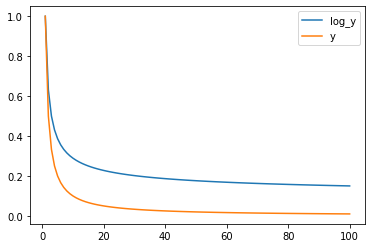

In [18]:
import matplotlib.pyplot as plt
import numpy as np

x = [i for i in range(1, 101)]
log_y = [1 / np.log2(i + 1)for i in x]
y = [1 / i for i in x]

plt.plot(x, log_y, label = 'log_y')
plt.plot(x, y, label = 'y')
plt.legend()
plt.show()